# Part B

Indeed, fraud in real life is often ambiguous. My goal here is **not** to identify fraud with absolute certainty, but rather flag suspicious activity for further follow up. I will explore the data with Python (mostly Pandas). Due to time constrains, my code might the most efficient possible, but it definitely does the job for any reasonably large dataset.

Suspicious areas for Part B:
- 2 entries have timestamps that exceeds 24:00 (i.e invalid)
- 1 entry has a booking timestamp identical to the dispatch time
- Harry's delivery activities are highly suspicious
    - He travels more distance in a day than humanly possible
    - He makes up to 23 trips to the same place in one day
    - The shopping cart value seems to be the same for more than 180 instances
    - The timings seems fabricated (using the random seconds technique)
- Same addresses but different coordinates


In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data tampering

Because the timestamps are all accurate to the second, I assume that they are machine generated. Machines do not make logical mistakes like exceeding boundary conditions. The existence of such mistakes points to signs of data tampering. Someone might have keyed in an entry into the system for a trip that did not happen

In [52]:
###Importing and cleaning data
prob_b = pd.read_csv('problem B.csv', parse_dates = ['data_date', 'booking_date', 'dispatch_time'])
prob_b = prob_b.dropna(axis = 1, how = 'all').dropna(axis = 0, how = 'all')

###Finding rows with invalid timestamps
error_rows = []
fixed_dt = []
for ind, row in prob_b.iterrows():
    try: 
        fixed_dt.append(pd.to_datetime(row['closing_time'], format='%Y-%m-%d %H:%M:%S'))
    except ValueError:
        error_rows.append(ind)

error_rows = prob_b.iloc[[95,128]]
df_b = prob_b.drop([95,128],axis = 0)
df_b['closing_time'] = fixed_dt

rows_to_show = ['booking_id', 'data_date', 'booking_date', 'dispatch_time', 'closing_time','driver_id', 'driver_name']
error_rows[rows_to_show]

,booking_id,data_date,booking_date,dispatch_time,closing_time,driver_id,driver_name
95,831687898.0,2017-04-07,2017-04-07 16:41:42,2017-04-07 16:45:21,2017-04-08 24:42:46+07,364589738.0,Tri W
128,832012030.0,2017-04-08,2017-04-08 16:55:41,2017-04-08 16:55:46,2017-04-09 24:16:26+07,364973164.0,Surdi


Taking a close look at the closing times, it exceeds the hours. These entries are extremely suspicious. We continue examining the timestamps for signs of manipulation. We will remove these 2 entries for the time being.

Logically, we expect closing time to be after dispatch time, which in turn is after booking date. However, one entry does not follow this rule.  

In [53]:
strange_entry = df_b[~((df_b['booking_date'] < df_b['dispatch_time']) & (
        df_b['dispatch_time'] < df_b['closing_time']))]
strange_entry[rows_to_show]

,booking_id,data_date,booking_date,dispatch_time,closing_time,driver_id,driver_name
62,831495358.0,2017-04-07,2017-04-07 06:13:00,2017-04-07 06:13:00,2017-04-07 06:29:41,364898625.0,Suhen


We can clearly see that *booking_date* is identical to the *dispatch_time*. Furthermore, the second entry is both 00, which points to the strong possibility that this entry has been tampered with.

### Is Harry Superman or SuperFraudster?

Harry, aka driver 364640292, has logged very suspicious activities. Let's first start with distance travelled daily. 

In [54]:
df_b[['driver_name','driver_id','total_distance']].groupby(['driver_name','driver_id']).sum().sort_values(
        'total_distance', ascending = False).head()

,,total_distance
driver_name,driver_id,
HARRY,364640292.0,4794.59
Surdi,364973164.0,27.32
Amrul,364487363.0,14.08
M. Al,364516183.0,12.50
Lukma,364820298.0,11.55


Harry, which we confirmed to be the only driver named as such, drove a distance of 4800 km in the week. We further break down harry's daily activities.

In [55]:
df_harry = df_b[df_b['driver_name'] == 'HARRY']
df_harry[['data_date', 'total_distance']].groupby('data_date').sum()

,total_distance
data_date,
2017-04-08,638.64
2017-04-09,4155.95


Harry drove a distance of 4156km on 9th April alone! That is humanly impossible, especially for a delivery van. Even driving for 24 hours, he still would have to go at a speed of above 150 km/h. Let's see where Harry is going with all these "trips".

In [56]:
df_harry[['data_date', 'customer_id','destination_address','total_distance']].groupby(
    ['data_date', 'customer_id','destination_address']).agg(['count','sum'])

total_distance  \
                                                                                   count   
data_date  customer_id destination_address                                                 
2017-04-08 249747620.0 Jalan Raya Sawangan, Pancoran MAS, Kota Depok                   6   
                       Jalan Tol Cawang Grogol, Pancoran, Kota Jakarta...              1   
           249894289.0 Jalan Dukuh 3, Pancoran MAS, Kota Depok                         2   
           249894626.0 Jalan Raya Sawangan, Pancoran MAS, Kota Depok                   6   
           249895739.0 Jalan Dewi Sartika, Pancoran MAS, Kota Depok                    6   
           249908000.0 Jalan Tol Jagorawi, , Bogor                                     3   
           249908602.0 Jalan Pahlawan, Citeureup, Bogor                                2   
2017-04-09 243194030.0 Jalan Vanda 1, Cimanggis, Kota Depok                            1   
           249747620.0 Gang Masjid, Pancoran MAS, Kota Depok                           5   
                       Jalan Raya Sawangan, Pancoran MAS, Kota Depok                  19   
           249894289.0 Jalan Dewi Sartika, Pancoran MAS, Kota Depok                   11   
                       Jalan Dukuh 3, Pancoran MAS, Kota Depok                         2   
                       Jalan Raya Sawangan, Pancoran MAS, Kota Depok                   9   
                       Jalan Salak, Pancoran MAS, Kota Depok                           5   
           249894626.0 Jalan Dewi Sartika, Pancoran MAS, Kota Depok                   11   
                       Jalan Raya Citayam, Pancoran MAS, Kota Depok                    1   
                       Jalan Raya Sawangan, Pancoran MAS, Kota Depok                  23   
           249895739.0 Gang Masjid, Pancoran MAS, Kota Depok                           6   
                       Jalan Dewi Sartika, Pancoran MAS, Kota Depok                   10   
                       Jalan Jambu V, Pancoran MAS, Kota Depok                         2   
                       Jalan Raya Sawangan, Pancoran MAS, Kota Depok                  10   
                       Jalan Salak, Pancoran MAS, Kota Depok                           6   
           249903719.0 Jalan Dewi Sartika, Pancoran MAS, Kota Depok                   10   
                       Jalan H.Usman S, Pancoran MAS, Kota Depok                       3   
                       Jalan Jambu V, Pancoran MAS, Kota Depok                         6   
                       Jalan Pitara Raya, Pancoran MAS, Kota Depok                     8   
                       Jalan Raya Sawangan, Pancoran MAS, Kota Depok                   4   
           249908000.0 Jalan Belimbing Sawah, Pancoran MAS, Kota Depok                14   
                       Jalan Salak, Pancoran MAS, Kota Depok                           5   

                                                                                   
                                                                              sum  
data_date  customer_id destination_address                                         
2017-04-08 249747620.0 Jalan Raya Sawangan, Pancoran MAS, Kota Depok       146.52  
                       Jalan Tol Cawang Grogol, Pancoran, Kota Jakarta...   24.21  
           249894289.0 Jalan Dukuh 3, Pancoran MAS, Kota Depok              49.28  
           249894626.0 Jalan Raya Sawangan, Pancoran MAS, Kota Depok       147.18  
           249895739.0 Jalan Dewi Sartika, Pancoran MAS, Kota Depok        147.84  
           249908000.0 Jalan Tol Jagorawi, , Bogor                          74.55  
           249908602.0 Jalan Pahlawan, Citeureup, Bogor                     49.06  
2017-04-09 243194030.0 Jalan Vanda 1, Cimanggis, Kota Depok                 16.58  
           249747620.0 Gang Masjid, Pancoran MAS, Kota Depok               123.90  
                       Jalan Raya Sawangan, Pancoran MAS, Kota Depok       462.33  
           249894289.0 Jalan Dewi Sar

Seems like Harry is capable and willing to make more than 20 trips to the same place for the same customer! In one day! More likely, Harry has fictiously logged trips that he did not make.

### Identical Shopping Carts?

Also, the shopping value of each trip is highly suspicious. 

In [57]:
df_harry['shopping_estimated_price'].value_counts()

40000.0    186
30000.0      7
60000.0      3
45000.0      1
Name: shopping_estimated_price, dtype: int64

It seems as though most shopping value entries are logged by harry as 40000. However, with more than 180 such instances, this is too much of a coincidence.

## Fooled by Randomness

Everyone plans the hour they wish to do something , some plan the minutes, but no one (unless you're weird) would plan the seconds. Few people in the right mind would say: I want to go out at 1:23 pm at the 36th second. Thus, one would expect that the seconds unit for a large enough sample to approximate a uniformly distribution UNLESS the timestamp has been manipulated with. Let's do this test on Harry.

32    19
29    18
4     18
8     18
26    15
dtype: int64


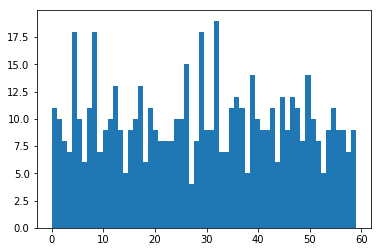

In [58]:
time_cols = ['booking_date', 'dispatch_time', 'closing_time']
driver_set = set(df_b['driver_name'])
harry_seconds = []
for time_col_name in time_cols:
    time_col = df_harry[time_col_name]
    harry_seconds.extend(list(time_col.apply(lambda row: row.second)))
plt.hist(harry_seconds, bins = 60)
print(pd.Series(harry_seconds).value_counts().head())
plt.show()

This is far from uniform. This makes Harry's records seem even more suspicious since there is a clear tendency for certain number and less for some. It is highly likely that the records have been tampered with. 

### 2 Coordinates with identical names?

Several entry with identical address, identical customer ID, but different coordinates

In [60]:
df_b[['destination_longitude', 'destination_latitude', 'destination_address']].set_index(
    ['destination_address']).sort_index().drop_duplicates()

,destination_longitude,destination_latitude
destination_address,,
"Ciangsana, Gn. Putri, Bogor, Jawa Barat 16968, Indonesia",106.956521,-6.358637
"Gang Arya Guna, Gunung Putri, Bogor",106.967798,-6.333502
"Gang Masjid, Pancoran MAS, Kota Depok",106.807655,-6.397761
"Gang Masjid, Pancoran MAS, Kota Depok",106.807735,-6.397938
"Jalan Bekasi Timur Regensi, Mustikajaya, Kota Bekasi",107.017424,-6.329617
"Jalan Belimbing Sawah, Pancoran MAS, Kota Depok",106.817260,-6.399893
"Jalan Belut Raya, Bekasi Selatan, Kota Bekasi",106.987915,-6.245362
"Jalan Bogor-Bekasi, Bantargebang, Kota Bekasi",106.981775,-6.363464
Jalan Boulevard Kota Wisata,106.955439,-6.376953


Of course, there is a good chance that this is because different parts of the same warehouse is being logged. However, this is still suspicious enough to dig deeper